# Redes Neurais com PyTorch

Este notebook serve como um guia introdutório ao desenvolvimento de redes neurais utilizando a biblioteca PyTorch. Abordaremos os componentes fundamentais da biblioteca, desde a manipulação de tensores até a construção e o treinamento de um modelo de rede neural para classificação de imagens.

## Conteúdos Abordados

1.  **Tensores e Grafos Computacionais**: A base do PyTorch.
2.  **O Módulo `torch.nn`**: Construindo camadas da rede.
3.  **Funções de Ativação**: Introduzindo não linearidade.
4.  **Construindo Modelos**: `nn.Sequential` e classes customizadas com `nn.Module`.
5.  **Datasets e DataLoaders**: Gerenciando e preparando dados com o `torchvision`.
6.  **Funções de Custo (Loss Functions)**: Quantificando o erro do modelo.
7.  **Otimizadores**: Atualizando os pesos do modelo.
8.  **Treinamento**: O ciclo completo de forward, backward e otimização.

## 1. Tensores e Grafos Computacionais

O `Tensor` é a estrutura de dados central do PyTorch. Trata-se de uma matriz multidimensional otimizada para operações em hardware especializado como GPUs. Os tensores são a base para a construção de grafos computacionais dinâmicos, que são essenciais para o cálculo automático de gradientes através do mecanismo de diferenciação automática, conhecido como `autograd`.

In [17]:
import torch

# Criando um tensor a partir de uma lista Python
data_list = [[1, 2], [3, 4]]
x_data = torch.tensor(data_list, dtype=torch.float32)
print(f"Tensor a partir de lista:\n {x_data}\n")

# Funções de criação de tensores
x_ones = torch.ones_like(x_data) # Cria um tensor de 'uns' com o mesmo formato de x_data
print(f"Tensor de 'uns':\n {x_ones} \n")

x_rand = torch.rand_like(x_data, dtype=torch.float) # Cria um tensor com valores aleatórios
print(f"Tensor aleatório:\n {x_rand} \n")

Tensor a partir de lista:
 tensor([[1., 2.],
        [3., 4.]])

Tensor de 'uns':
 tensor([[1., 1.],
        [1., 1.]]) 

Tensor aleatório:
 tensor([[0.6483, 0.3764],
        [0.8243, 0.9079]]) 



### O Grafo Computacional e o `requires_grad`

Cada tensor possui um atributo booleano chamado `requires_grad`. Se definido como `True`, o `autograd` rastreia todas as operações realizadas neste tensor. Ao final de uma cadeia de operações (tipicamente, o cálculo de uma função de custo), a chamada do método `.backward()` no tensor de saída (que deve ser um escalar) dispara o cálculo dos gradientes de forma retroativa através do grafo, aplicando a regra da cadeia (chain rule).

Considere a seguinte função, onde $a$, $b$, e $c$ são tensores de entrada:
$$
L = (a \cdot b - c)^2
$$
O `autograd` precisa calcular as derivadas parciais de $L$ em relação a $a$, $b$ e $c$, ou seja, $\frac{\partial L}{\partial a}$, $\frac{\partial L}{\partial b}$, e $\frac{\partial L}{\partial c}$. Para calcular $\frac{\partial L}{\partial a}$, por exemplo, a regra da cadeia se desdobra da seguinte forma, sendo $z = a \cdot b - c$:
$$
\frac{\partial L}{\partial a} = \frac{\partial L}{\partial z} \cdot \frac{\partial z}{\partial a}
$$
Onde $\frac{\partial L}{\partial z} = 2z = 2(a \cdot b - c)$ e $\frac{\partial z}{\partial a} = b$. O PyTorch realiza este processo de forma automática para todos os parâmetros com `requires_grad=True`.

In [19]:
# Implementando o exemplo matemático com autograd
# Definindo os tensores de entrada que requerem gradiente
a = torch.tensor(4.0, requires_grad=True)
b = torch.tensor(5.0, requires_grad=True)
c = torch.tensor(2.0, requires_grad=True)

# Sequência de operações
z = a * b - c
L = z**2

# O tensor 'L' agora possui uma função de gradiente que armazena o grafo
print(f"Tensor de saída L: {L}")
print(f"Função de gradiente de L: {L.grad_fn}\n")

# Calculando os gradientes (backward pass)
L.backward()

# Os gradientes são acumulados no atributo .grad de cada tensor
print(f"Gradiente dL/da: {a.grad}") # Esperado: 2 * (4*5 - 2) * 5 = 180
print(f"Gradiente dL/db: {b.grad}") # Esperado: 2 * (4*5 - 2) * 4 = 144
print(f"Gradiente dL/dc: {c.grad}") # Esperado: 2 * (4*5 - 2) * (-1) = -36

Tensor de saída L: 324.0
Função de gradiente de L: <PowBackward0 object at 0x74d3cc2a7160>

Gradiente dL/da: 180.0
Gradiente dL/db: 144.0
Gradiente dL/dc: -36.0


## 2. O Módulo `torch.nn`

O `torch.nn` é o módulo do PyTorch para a construção de redes neurais. Ele fornece um conjunto de blocos de construção, como camadas (`Layers`), funções de ativação (`Activation Functions`), funções de custo (`Loss Functions`) e contêineres (`Containers`). Uma "camada" no `torch.nn` é um objeto que encapsula tanto os pesos (parâmetros) quanto as operações a serem aplicadas nos dados de entrada.

### Camada Linear: `nn.Linear`

A camada mais fundamental é a `nn.Linear`, que aplica uma transformação afim aos dados de entrada: $y = xW^T + b$.

-   `in_features`: a dimensionalidade do espaço de entrada.
-   `out_features`: a dimensionalidade do espaço de saída.

Os tensores de peso (`weight`, $W$) e de viés (`bias`, $b$) são encapsulados como `nn.Parameter`, uma subclasse de `torch.Tensor` que os registra automaticamente como parâmetros de um `nn.Module`.

In [20]:
from torch import nn

# Definindo uma camada linear
# Entrada: 10 features
# Saída: 5 features
linear_layer = nn.Linear(in_features=10, out_features=5)

# Criando um tensor de entrada de exemplo (um "batch" com 3 amostras)
# O formato é (batch_size, in_features)
input_tensor = torch.randn(3, 10)

# Passando os dados pela camada
output_tensor = linear_layer(input_tensor)

print(f"Formato do tensor de entrada: {input_tensor.shape}")
print(f"Formato do tensor de saída: {output_tensor.shape}")
print(f"\nPesos (weights) da camada:\n {linear_layer.weight.shape}")
print(f"Viés (bias) da camada:\n {linear_layer.bias.shape}")

Formato do tensor de entrada: torch.Size([3, 10])
Formato do tensor de saída: torch.Size([3, 5])

Pesos (weights) da camada:
 torch.Size([5, 10])
Viés (bias) da camada:
 torch.Size([5])


## 3. Funções de Ativação

Funções de ativação introduzem não linearidade no modelo, capacitando-o a aprender fronteiras de decisão complexas. Elas são aplicadas elemento a elemento na saída de uma camada.

### Funções Comuns

-   **Sigmoid**: Comprime os valores de entrada no intervalo $(0, 1)$. Utilizada historicamente em camadas ocultas e atualmente em camadas de saída para classificação binária.
    $$ \sigma(x) = \frac{1}{1 + e^{-x}} $$
-   **Tanh (Tangente Hiperbólica)**: Comprime os valores de entrada no intervalo $(-1, 1)$. Geralmente converge mais rápido que a Sigmoid por ser centrada em zero.
    $$ \tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}} $$
-   **ReLU (Rectified Linear Unit)**: A função de ativação mais utilizada em redes profundas. É computacionalmente eficiente e ajuda a mitigar o problema do desaparecimento do gradiente (vanishing gradient).
    $$ \text{ReLU}(x) = \max(0, x) $$
-   **Leaky ReLU**: Uma variação da ReLU que permite a passagem de um pequeno gradiente negativo, prevenindo o problema dos "neurônios mortos".
    $$ \text{LeakyReLU}(x) = \begin{cases} x, & \text{if } x > 0 \\ \alpha x, & \text{otherwise} \end{cases} $$
-   **Softmax**: Transforma um vetor de números reais (logits) em uma distribuição de probabilidade sobre múltiplas classes. Utilizada na camada de saída para classificação multiclasse.
    $$ \text{Softmax}(x_i) = \frac{e^{x_i}}{\sum_{j} e^{x_j}} $$

In [21]:
# As funções de ativação também estão no módulo nn
relu_activation = nn.ReLU()
leaky_relu_activation = nn.LeakyReLU()

# Aplicando a ativação na saída da camada linear anterior
output_with_relu = relu_activation(output_tensor)
output_with_leaky_relu = leaky_relu_activation(output_tensor)

print(f"Saída da camada linear:\n {output_tensor}\n")
print(f"Saída após ativação ReLU:\n {output_with_relu}\n")
print(f"Saída após ativação Leaky ReLU:\n {output_with_leaky_relu}")

Saída da camada linear:
 tensor([[ 0.4033, -0.5988,  0.0348, -1.5665, -1.1932],
        [-0.7381,  1.9516,  0.7010,  0.8184,  0.7685],
        [ 0.2085, -0.6269, -0.0235, -0.4302, -0.6329]],
       grad_fn=<AddmmBackward0>)

Saída após ativação ReLU:
 tensor([[0.4033, 0.0000, 0.0348, 0.0000, 0.0000],
        [0.0000, 1.9516, 0.7010, 0.8184, 0.7685],
        [0.2085, 0.0000, 0.0000, 0.0000, 0.0000]], grad_fn=<ReluBackward0>)

Saída após ativação Leaky ReLU:
 tensor([[ 4.0327e-01, -5.9880e-03,  3.4799e-02, -1.5665e-02, -1.1932e-02],
        [-7.3807e-03,  1.9516e+00,  7.0102e-01,  8.1835e-01,  7.6853e-01],
        [ 2.0845e-01, -6.2691e-03, -2.3507e-04, -4.3018e-03, -6.3285e-03]],
       grad_fn=<LeakyReluBackward0>)


## 4. Construindo Modelos

O PyTorch oferece duas maneiras principais de agrupar camadas para formar um modelo completo.

### `nn.Sequential`

`nn.Sequential` é um contêiner que recebe uma sequência de módulos (camadas, funções de ativação, etc.) e os executa na ordem em que são passados. É uma forma rápida e simples de criar modelos onde os dados fluem sequencialmente através das camadas.

In [22]:
# Construindo um modelo simples com nn.Sequential
# Input (784) -> Linear (128) -> ReLU -> Linear (10) -> Output
model_sequential = nn.Sequential(
    nn.Linear(in_features=784, out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=10)
)

# Criando um tensor de entrada de exemplo (batch com 64 imagens achatadas de 28x28)
# 28 * 28 = 784
input_images = torch.randn(64, 784)

# Forward pass através do modelo sequencial
logits = model_sequential(input_images) # 'logits' são as saídas brutas antes da probabilidade

print(f"Formato da saída do modelo: {logits.shape}")

Formato da saída do modelo: torch.Size([64, 10])


### Classes customizadas com `nn.Module`

Para modelos mais complexos, como aqueles com múltiplos caminhos de entrada/saída ou lógicas de *forward pass* não sequenciais (e.g., redes residuais), a abordagem recomendada é criar uma classe que herda de `nn.Module`.

Toda classe de modelo customizada deve:
1.  Herdar de `torch.nn.Module`.
2.  Definir as camadas no construtor `__init__(self)`.
3.  Implementar a lógica do *forward pass* no método `forward(self, x)`.

O método `backward()` é gerenciado automaticamente pelo `autograd`.

In [23]:
# Definindo o mesmo modelo anterior, mas agora como uma classe
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.relu(out)
        out = self.layer2(out)
        return out

# Instanciando o modelo
model_class = NeuralNetwork(input_size=784, hidden_size=128, num_classes=10)

# O uso é idêntico
logits_class = model_class(input_images)

print(f"Formato da saída do modelo (classe): {logits_class.shape}")
print(f"\nEstrutura do modelo:\n{model_class}")

Formato da saída do modelo (classe): torch.Size([64, 10])

Estrutura do modelo:
NeuralNetwork(
  (layer1): Linear(in_features=784, out_features=128, bias=True)
  (relu): ReLU()
  (layer2): Linear(in_features=128, out_features=10, bias=True)
)


## 5. Datasets e DataLoaders

Para treinar um modelo, precisamos de dados. O `torch.utils.data.Dataset` é uma classe abstrata que representa um dataset. O `torch.utils.data.DataLoader` é um iterador que envolve um `Dataset` e oferece funcionalidades como:

-   Agrupamento dos dados em *batches* (lotes).
-   Embaralhamento dos dados a cada época (`shuffle=True`).
-   Carregamento de dados em paralelo usando múltiplos processos (`num_workers`).

Um **batch** é um subconjunto do dataset total. Em vez de calcular o gradiente com base em todo o dataset de uma só vez (o que seria computacionalmente caro), o treinamento é feito iterativamente em batches. Isso torna o processo de treinamento mais eficiente e pode levar a uma convergência mais estável.

A biblioteca `torchvision` contém datasets populares (como o MNIST), modelos pré-treinados e transformações de imagem.

In [24]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Definindo transformações para os dados
# ToTensor() converte a imagem PIL (H x W x C) no intervalo [0, 255]
# para um FloatTensor (C x H x W) no intervalo [0.0, 1.0].
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # Média e desvio padrão do MNIST
])

# Baixando o dataset de treino
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

# Baixando o dataset de teste
test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    transform=transform
)

In [25]:
# Criando os DataLoaders
batch_size = 100
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

# Iterando sobre o DataLoader para ver o formato de um batch
images, labels = next(iter(train_loader))
print(f"Formato do batch de imagens: {images.shape}") # (batch_size, channels, height, width)
print(f"Formato do batch de rótulos: {labels.shape}")

Formato do batch de imagens: torch.Size([100, 1, 28, 28])
Formato do batch de rótulos: torch.Size([100])


## 6. Funções de Custo (Loss Functions)

A função de custo $J(\theta)$ mede a discrepância entre a saída prevista pelo modelo $\hat{y}$ e o valor real $y$. O objetivo do treinamento é encontrar os parâmetros $\theta$ que minimizam $J(\theta)$.

### Funções Comuns

-   **Mean Squared Error (MSE)**: Utilizada principalmente para tarefas de regressão. Calcula a média dos erros quadráticos entre a previsão e o valor real.
    $$ J_{MSE} = \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2 $$
-   **Binary Cross-Entropy (BCE)**: Utilizada para classificação binária. Geralmente é combinada com uma camada de saída Sigmoid.
    $$ J_{BCE} = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right] $$
-   **Cross-Entropy Loss**: Utilizada para classificação multiclasse. No PyTorch, `nn.CrossEntropyLoss` combina `nn.LogSoftmax` e `nn.NLLLoss`, sendo numericamente mais estável. Ela espera como entrada os *logits* brutos do modelo e os rótulos de classe como inteiros.
    $$ J_{CE} = -\frac{1}{N} \sum_{i=1}^{N} \sum_{c=1}^{C} y_{i,c} \log(\hat{p}_{i,c}) $$
    Onde $y_{i,c}$ é 1 se a amostra $i$ pertence à classe $c$ (0 caso contrário), e $\hat{p}_{i,c}$ é a probabilidade prevista pelo modelo para a amostra $i$ pertencer à classe $c$.

In [26]:
# Instanciando a função de custo para classificação multiclasse
loss_function = nn.CrossEntropyLoss()

# Exemplo de uso:
# Saída do modelo (logits) para um batch de 3 amostras e 10 classes
output_logits = torch.randn(3, 10)
# Rótulos verdadeiros
target_labels = torch.tensor([1, 4, 9]) # Classe 1, Classe 4, Classe 9

# Calculando a perda
loss = loss_function(output_logits, target_labels)
print(f"Valor da perda (loss): {loss.item()}")

Valor da perda (loss): 1.7836055755615234


## 7. Otimizadores

O otimizador implementa o algoritmo de atualização dos parâmetros do modelo, $\theta$, com base nos gradientes da função de custo, $\nabla_{\theta} J(\theta)$. O objetivo é convergir para um mínimo (local ou global) da função de custo.

O algoritmo mais fundamental é o **Stochastic Gradient Descent (SGD)**. A regra de atualização para um parâmetro $\theta$ no passo de tempo $t$ é definida como:
$$
\theta_{t+1} = \theta_t - \eta \nabla_{\theta} J(\theta_t)
$$
onde $\eta$ é a taxa de aprendizado (*learning rate*), um hiperparâmetro que controla o tamanho do passo na direção do gradiente negativo.

Otimizadores mais avançados, como o **Adam (Adaptive Moment Estimation)**, utilizam taxas de aprendizado adaptativas para cada parâmetro, mantendo uma estimativa do primeiro momento (a média) e do segundo momento (a variância não centrada) dos gradientes, o que frequentemente leva a uma convergência mais rápida.

In [27]:
# Instanciando o modelo
learning_rate = 0.001
model = NeuralNetwork(input_size=784, hidden_size=128, num_classes=10)

# Instanciando o otimizador Adam
# Passamos os parâmetros do modelo que devem ser otimizados (model.parameters())
# e a taxa de aprendizado (lr).
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# O otimizador possui métodos cruciais:
# optimizer.zero_grad(): Zera os gradientes de todos os parâmetros antes de um novo cálculo de backward pass.
#   Isto é necessário porque o método .backward() acumula os gradientes por padrão.
#
# optimizer.step(): Atualiza os parâmetros do modelo usando a lógica do otimizador (e.g., Adam) e os gradientes
#   armazenados no atributo .grad de cada parâmetro.

## 8. Treinamento: O Ciclo Completo

O treinamento de uma rede neural consiste em um loop que itera sobre o dataset por várias "épocas" (*epochs*). Uma época é uma passagem completa por todo o dataset de treinamento. Dentro de cada época, iteramos sobre os *batches* de dados.

Para cada *batch*, o ciclo de treinamento é:
1.  **Zerar os gradientes**: Chamar `optimizer.zero_grad()`.
2.  **Forward Pass**: Passar os dados de entrada pelo modelo para obter as previsões (logits).
3.  **Calcular a Perda**: Comparar as previsões com os rótulos verdadeiros usando a função de custo.
4.  **Backward Pass**: Chamar `loss.backward()` para calcular os gradientes da perda em relação a cada parâmetro do modelo.
5.  **Atualizar os Pesos**: Chamar `optimizer.step()` para que o otimizador atualize os pesos com base nos gradientes.

In [33]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Hiperparâmetros
num_epochs = 5
input_size = 784 # 28x28
hidden_size = 500
num_classes = 10
learning_rate = 0.001

# Dispositivo (GPU se disponível, senão CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando o dispositivo: {device}")

# Instanciando o modelo, função de custo e otimizador e movendo o modelo para o dispositivo
model = NeuralNetwork(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Listas para armazenar as métricas de cada época
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Loop de treinamento
for epoch in range(num_epochs):
    # --- Treinamento ---
    model.train() # Coloca o modelo em modo de treinamento
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    progress_bar_train = tqdm(train_loader, desc=f'Época [{epoch+1}/{num_epochs}] Treino')
    
    for images, labels in progress_bar_train:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward e otimização
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Calcula a acurácia de treino
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
        progress_bar_train.set_postfix({'Perda Treino': f'{loss.item():.4f}'})
        
    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_acc = 100 * correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)

    # --- Validação ---
    model.eval() # Coloca o modelo em modo de avaliação
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    progress_bar_val = tqdm(test_loader, desc=f'Época [{epoch+1}/{num_epochs}] Validação')
    
    with torch.no_grad(): # Desabilita o cálculo de gradientes
        for images, labels in progress_bar_val:
            images = images.reshape(-1, 28*28).to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            
            # Calcula a acurácia de validação
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            
            progress_bar_val.set_postfix({'Perda Val': f'{loss.item():.4f}'})

    epoch_val_loss = running_val_loss / len(test_loader)
    epoch_val_acc = 100 * correct_val / total_val
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)
    
    print(f'Fim da Época [{epoch+1}/{num_epochs}] | '
          f'Perda Treino: {epoch_train_loss:.4f}, Acurácia Treino: {epoch_train_acc:.2f}% | '
          f'Perda Validação: {epoch_val_loss:.4f}, Acurácia Validação: {epoch_val_acc:.2f}%')

print("\nTreinamento concluído!")

Usando o dispositivo: cuda


Época [1/5] Treino:   0%|          | 0/600 [00:00<?, ?it/s]

Época [1/5] Validação:   0%|          | 0/100 [00:00<?, ?it/s]

Fim da Época [1/5] | Perda Treino: 0.2242, Acurácia Treino: 93.37% | Perda Validação: 0.1081, Acurácia Validação: 96.71%


Época [2/5] Treino:   0%|          | 0/600 [00:00<?, ?it/s]

Época [2/5] Validação:   0%|          | 0/100 [00:00<?, ?it/s]

Fim da Época [2/5] | Perda Treino: 0.0872, Acurácia Treino: 97.37% | Perda Validação: 0.0872, Acurácia Validação: 97.39%


Época [3/5] Treino:   0%|          | 0/600 [00:00<?, ?it/s]

Época [3/5] Validação:   0%|          | 0/100 [00:00<?, ?it/s]

Fim da Época [3/5] | Perda Treino: 0.0586, Acurácia Treino: 98.11% | Perda Validação: 0.0648, Acurácia Validação: 97.97%


Época [4/5] Treino:   0%|          | 0/600 [00:00<?, ?it/s]

Época [4/5] Validação:   0%|          | 0/100 [00:00<?, ?it/s]

Fim da Época [4/5] | Perda Treino: 0.0392, Acurácia Treino: 98.73% | Perda Validação: 0.0732, Acurácia Validação: 97.77%


Época [5/5] Treino:   0%|          | 0/600 [00:00<?, ?it/s]

Época [5/5] Validação:   0%|          | 0/100 [00:00<?, ?it/s]

Fim da Época [5/5] | Perda Treino: 0.0317, Acurácia Treino: 98.97% | Perda Validação: 0.0635, Acurácia Validação: 98.00%

Treinamento concluído!


### Visualização das Curvas de Aprendizado

As curvas de aprendizado plotam as métricas de desempenho (como perda e acurácia) para os conjuntos de treinamento e validação ao longo das épocas. Elas são ferramentas de diagnóstico essenciais:

-   **Curva de Perda (Loss Curve)**: Mostra a evolução da função de custo. Idealmente, ambas as perdas (treino e validação) devem diminuir. Se a perda de validação começar a aumentar enquanto a de treino continua caindo, é um sinal claro de *overfitting*.
-   **Curva de Acurácia (Accuracy Curve)**: Mostra a evolução da acurácia. Idealmente, ambas devem aumentar e convergir. Uma grande diferença entre a acurácia de treino e a de validação também indica *overfitting*.

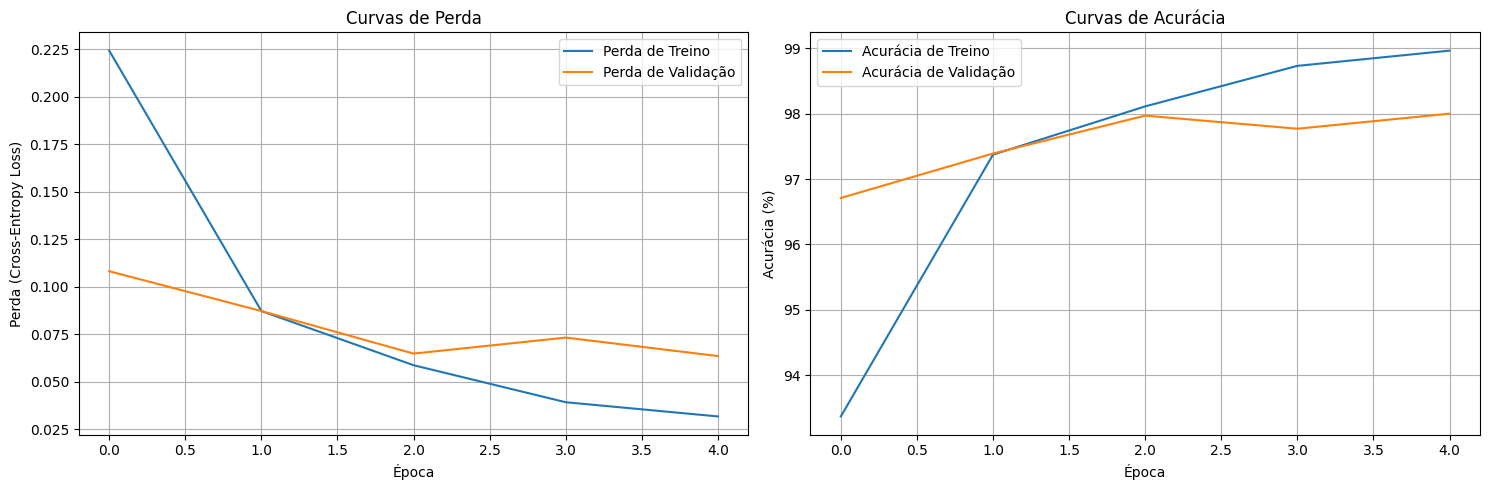

In [34]:
# Criando os plots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot da Curva de Perda
axs[0].plot(train_losses, label='Perda de Treino')
axs[0].plot(val_losses, label='Perda de Validação')
axs[0].set_title("Curvas de Perda")
axs[0].set_xlabel("Época")
axs[0].set_ylabel("Perda (Cross-Entropy Loss)")
axs[0].legend()
axs[0].grid(True)

# Plot da Curva de Acurácia
axs[1].plot(train_accuracies, label='Acurácia de Treino')
axs[1].plot(val_accuracies, label='Acurácia de Validação')
axs[1].set_title("Curvas de Acurácia")
axs[1].set_xlabel("Época")
axs[1].set_ylabel("Acurácia (%)")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

### Avaliação do Modelo

Após o treinamento, é fundamental avaliar a performance do modelo em dados que ele nunca viu, ou seja, o conjunto de teste. Durante a avaliação, não precisamos calcular gradientes, o que economiza memória e computação. Para isso, usamos o contexto `torch.no_grad()`.

In [35]:
# Colocando o modelo em modo de avaliação (desativa camadas como Dropout, se houver)
model.eval()

# O contexto torch.no_grad() desabilita o cálculo de gradientes
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        
        # A classe com o maior logit é a previsão
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Acurácia do modelo no dataset de teste: {100 * correct / total:.2f} %')

Acurácia do modelo no dataset de teste: 98.00 %
